In [1]:
!pip install praw

In [29]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
import string
from nltk.stem import PorterStemmer
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report
import praw
import pandas as pd
from datetime import datetime as dt
from dotenv import load_dotenv
from os import getenv

In [31]:
load_dotenv()

True

In [33]:
getenv("APP_ID")

'MXhHjxHpVO7DibCXry8dlA'

In [43]:
reddit = praw.Reddit(
    client_id=getenv("APP_ID"), # Right below 'personal use script'
    client_secret=getenv("APP_SECRET"), # secret
    user_agent=f"pda-2023 u/{getenv('USERNAME')}", # app-name u/username
)


In [45]:
print(reddit.read_only)

True


# SENTIMENT ANALYSIS

## READING DATA

In [203]:
#reading data from reddit
print(reddit.read_only)
subreddit = reddit.subreddit("RenewableEnergy")

True


In [205]:
#display name of subreddit
print(subreddit.display_name)
# If the api is not connected, the following will give a 401 error
print(subreddit.title)
print(subreddit.description)


RenewableEnergy
Renewable Energy: safe, clean, sustainable energy for our future
>> * [Energy](/r/BigEnergy+Biomass+Energy+RenewableEnergy+Solar+Wind/new)
>>     * /r/BigEnergy
>>     * /r/Biomass
>>     * /r/Energy
>>     * /r/RenewableEnergy
>>     * /r/Solar
>>     * /r/Wind

>> * [Environment](/r/AntiPoaching+Awwducational+Biodynamic+Birding+Climate+ClimateChange+ClimateNews+Conservation+Drylands+Divestment+Drought+EcoFeminism+Ecology+EnviroAction+EnviroNews+Environment+Environmental_Policy+FactoryFarms+GreenNewDeal+Green+LifeAquatic+NationalPark+Nature+Ocean+Oceans+Organic+PermaCulture+ReWilding+RenewableEnergy+RenewableNews+Restoration_Ecology+Sustainability+Sustainable+Shipwrecks+Trappit+Underwaterphotography+Veg+Water+Wetlands+Wildlife+zerowaste/new)
>>     * /r/AntiPoaching
>>     * /r/Awwducational
>>     * /r/Biodynamic
>>     * /r/Birding
>>     * /r/Climate
>>     * /r/ClimateChange
>>     * /r/ClimateNews
>>     * /r/Conservation
>>     * /r/Divestment
>>     * /r/Drought

In [207]:
#print titles and comments
for post in subreddit.new(limit=10):
    print("***************")
    print(post.title)
    for comment in list(post.comments):
        print(comment.body)
        print(comment.created_utc)
        print(dt.fromtimestamp(comment.created_utc))
        print("---------")
#     print("in the indent")
# print("outside the indent")



***************
U.S. Offshore Wind Industry Faces Uncertainty: Political Roadblocks and Global Impacts
***************
Japan's greenhouse gas emissions fall 4% in FY23/24 to record low
Brilliant news 
1745773118.0
2025-04-27 21:58:38
---------
Population fell as well
1745766288.0
2025-04-27 20:04:48
---------
Did they change the way they measured?
1745785706.0
2025-04-28 01:28:26
---------
Rare good news
1745790089.0
2025-04-28 02:41:29
---------
What about per capita?
1745791124.0
2025-04-28 02:58:44
---------
***************
Grid-Scale Battery Storage Is Quietly Revolutionizing the Energy System | WIRED
12 GWHs next year is bonkers. Peaker plants in California will be gone in a few years if they keep that up.
1745708870.0
2025-04-27 04:07:50
---------
Battery storage is fucking awesome. As an energy scientist, modeling the grid, I’m always amazed how giant batteries drop the price of electricity. If you were trying to solve one of the most complex problems on the planet, and you were

In [209]:
postTitles = []
postTimes = []
comment_bodies = []
comment_times = []
#post_titles = []
for post in subreddit.new(limit=10):
    postTitles.append(post.title)
    postTimes.append(dt.fromtimestamp(post.created_utc))



In [211]:
#store titles and theri timings in a dataframe
df = pd.DataFrame({
    "Post Title": postTitles,
    "Post Time" : postTimes
})

#view first 5 rows of dataframe
df.head()



,Post Title,Post Time
0,U.S. Offshore Wind Industry Faces Uncertainty:...,2025-04-28 16:58:32
1,Japan's greenhouse gas emissions fall 4% in FY...,2025-04-27 19:42:24
2,Grid-Scale Battery Storage Is Quietly Revoluti...,2025-04-27 02:22:57
3,Ethanol corn uses farmland area the size of Ne...,2025-04-26 00:07:40
4,"Meanwhile, in China, 60 GW of new solar capaci...",2025-04-25 19:44:03


In [213]:
#save comments to csv file
df.to_csv("Reddit Python Posts.csv", index=False)
#read comments from csv file
df2 = pd.read_csv("Reddit Python Posts.csv")

df2.head()

,Post Title,Post Time
0,U.S. Offshore Wind Industry Faces Uncertainty:...,2025-04-28 16:58:32
1,Japan's greenhouse gas emissions fall 4% in FY...,2025-04-27 19:42:24
2,Grid-Scale Battery Storage Is Quietly Revoluti...,2025-04-27 02:22:57
3,Ethanol corn uses farmland area the size of Ne...,2025-04-26 00:07:40
4,"Meanwhile, in China, 60 GW of new solar capaci...",2025-04-25 19:44:03


In [217]:
#Access the 'energy' subreddit
subreddit = reddit.subreddit("RenewableEnergy")

print(subreddit.display_name)
print(subreddit.title)
print(subreddit.description)

RenewableEnergy
Renewable Energy: safe, clean, sustainable energy for our future
>> * [Energy](/r/BigEnergy+Biomass+Energy+RenewableEnergy+Solar+Wind/new)
>>     * /r/BigEnergy
>>     * /r/Biomass
>>     * /r/Energy
>>     * /r/RenewableEnergy
>>     * /r/Solar
>>     * /r/Wind

>> * [Environment](/r/AntiPoaching+Awwducational+Biodynamic+Birding+Climate+ClimateChange+ClimateNews+Conservation+Drylands+Divestment+Drought+EcoFeminism+Ecology+EnviroAction+EnviroNews+Environment+Environmental_Policy+FactoryFarms+GreenNewDeal+Green+LifeAquatic+NationalPark+Nature+Ocean+Oceans+Organic+PermaCulture+ReWilding+RenewableEnergy+RenewableNews+Restoration_Ecology+Sustainability+Sustainable+Shipwrecks+Trappit+Underwaterphotography+Veg+Water+Wetlands+Wildlife+zerowaste/new)
>>     * /r/AntiPoaching
>>     * /r/Awwducational
>>     * /r/Biodynamic
>>     * /r/Birding
>>     * /r/Climate
>>     * /r/ClimateChange
>>     * /r/ClimateNews
>>     * /r/Conservation
>>     * /r/Divestment
>>     * /r/Drought

In [219]:


# Create lists to collect comment data
comment_bodies = []
comment_times = []
post_titles = []

for post in subreddit.new(limit=10):
    print("***************")
    print(post.title)
    post.comments.replace_more(limit=None)  # VERY IMPORTANT: expand all comments
    
    for comment in post.comments.list():
        if comment.body:  # make sure the comment is not empty
            # Filtering for 'Ireland' and 'price'
            #if 'ireland' in comment.body.lower():
            #if 'ireland' in comment.body.lower() and 'fuel prices' in comment.body.lower():
            comment_bodies.append(comment.body)
            comment_times.append(dt.fromtimestamp(comment.created_utc))
            post_titles.append(post.title)



***************
U.S. Offshore Wind Industry Faces Uncertainty: Political Roadblocks and Global Impacts
***************
Japan's greenhouse gas emissions fall 4% in FY23/24 to record low
***************
Grid-Scale Battery Storage Is Quietly Revolutionizing the Energy System | WIRED
***************
Ethanol corn uses farmland area the size of New York — could solar do it better?
***************
Meanwhile, in China, 60 GW of new solar capacity added in first quarter of 2025 | RenewEconomy
***************
Switzerland inaugurates first rail track solar power project
***************
Record wind power capacity was installed globally in 2024
***************
Xi contrasts China’s clean energy promises with Trump turmoil
***************
Spain hits first weekday of 100% renewable power on national grid – pv magazine International
***************
US to impose tariffs of up to 3,521% on south-east Asia solar panels


In [221]:
# Create a DataFrame
df_comments = pd.DataFrame({
    "Post Title": post_titles,
    "Comment Body": comment_bodies,
    "Comment Time": comment_times
})


In [223]:
df_comments.head()

,Post Title,Comment Body,Comment Time
0,Japan's greenhouse gas emissions fall 4% in FY...,Brilliant news,2025-04-27 21:58:38
1,Japan's greenhouse gas emissions fall 4% in FY...,Population fell as well,2025-04-27 20:04:48
2,Japan's greenhouse gas emissions fall 4% in FY...,Did they change the way they measured?,2025-04-28 01:28:26
3,Japan's greenhouse gas emissions fall 4% in FY...,Rare good news,2025-04-28 02:41:29
4,Japan's greenhouse gas emissions fall 4% in FY...,What about per capita?,2025-04-28 02:58:44


In [225]:
df_comments.shape

(273, 3)

In [13]:

# Save to CSV
df_comments.to_csv("Reddit_Energy_Comments.csv", index=False)

# Read back the CSV
df2 = pd.read_csv("Reddit_Energy_Comments.csv")

print(df2.head())

                                          Post Title  \
0  Japan's greenhouse gas emissions fall 4% in FY...   
1  Japan's greenhouse gas emissions fall 4% in FY...   
2  Japan's greenhouse gas emissions fall 4% in FY...   
3  Japan's greenhouse gas emissions fall 4% in FY...   
4  Japan's greenhouse gas emissions fall 4% in FY...   

                             Comment Body         Comment Time  
0                         Brilliant news   2025-04-27 21:58:38  
1                 Population fell as well  2025-04-27 20:04:48  
2  Did they change the way they measured?  2025-04-28 01:28:26  
3                          Rare good news  2025-04-28 02:41:29  
4                  What about per capita?  2025-04-28 02:58:44  


## CLEANING DATA

In [15]:
#import pandas as pd
#import nltk
#from nltk.corpus import stopwords
#nltk.download('stopwords')
#import string
#from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# Store the stopwords into the object named as "stop_words"
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Store the string.punctuation into an object punct
punct = string.punctuation

# Initialise an object using a method PorterStemmer
stemmer = PorterStemmer()

In [19]:
X=df2['Comment Body']
print(X)

0                                        Brilliant news 
1                                Population fell as well
2                 Did they change the way they measured?
3                                         Rare good news
4                                 What about per capita?
                             ...                        
268    I was just reading on a trade website that mos...
269    Wherever you got your engineering degree, you ...
270                          Mission solar, first solar?
271    Just eyeballing those numbers the capacity is ...
272    They don’t need to sell abroad - countries wil...
Name: Comment Body, Length: 273, dtype: object


In [29]:
#import re

cleaned_data=[]
#X=df2['Comment Body']
# For loop from first value to length(X), ^a-zA-Z0-9 means include small and capital case letters and numerics

for i in range(len(X)):
    tweet = re.sub('[^a-zA-Z0-9]', ' ', X.iloc[i])
    tweet = tweet.lower().split()
    tweet = [stemmer.stem(word) for word in tweet if (word not in stop_words) and (word not in punct)]
    tweet = ' '.join(tweet)
    cleaned_data.append(tweet)

In [31]:
cleaned_data

['brilliant news',
 'popul fell well',
 'chang way measur',
 'rare good news',
 'per capita',
 '4',
 'japan citizen popul dip 120 3 million octob 2024 offici data show monday mark record drop 898 000 peopl previou year sauc http www dw com en japan see record drop popul 72239612 0 898 120 3 0 898 0 00741 1 6th 4',
 'peopl realli need simpl old fact check',
 '12 gwh next year bonker peaker plant california gone year keep',
 'batteri storag fuck awesom energi scientist model grid alway amaz giant batteri drop price electr tri solv one complex problem planet think way solv problem spec chanc design li ion batteri storag fast reliabl cheap support grid matter crazi congest extrem weather intermitt resourc etc etc',
 'interest side effect grid scale batteri storag power come back end much cleaner green free voltag frequenc variat batteri storag switch millisecond sinc power immedi avail',
 'adopt acceler technolog continu becom cheaper',
 'great could batteri propos increas effici coal natu

In [37]:
df2['Cleaned Comment'] = cleaned_data


In [39]:
df2.head()

,Post Title,Comment Body,Comment Time,Cleaned Comment
0,Japan's greenhouse gas emissions fall 4% in FY...,Brilliant news,2025-04-27 21:58:38,brilliant news
1,Japan's greenhouse gas emissions fall 4% in FY...,Population fell as well,2025-04-27 20:04:48,popul fell well
2,Japan's greenhouse gas emissions fall 4% in FY...,Did they change the way they measured?,2025-04-28 01:28:26,chang way measur
3,Japan's greenhouse gas emissions fall 4% in FY...,Rare good news,2025-04-28 02:41:29,rare good news
4,Japan's greenhouse gas emissions fall 4% in FY...,What about per capita?,2025-04-28 02:58:44,per capita


In [ ]:
#Starting sentiment analysis

## VADER ANALYSIS

In [43]:
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [45]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [97]:
# Load thelibraries
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# Create and initialise an object
sentiment = SentimentIntensityAnalyzer()

In [49]:
#Applying VADER to every comment
# Create empty lists to store results
vader_compound = []
vader_pos = []
vader_neu = []
vader_neg = []

# Loop over every comment
for comment in df2['Cleaned Comment']:
    scores = sentiment.polarity_scores(str(comment))  # VADER returns a dictionary
    vader_compound.append(scores['compound'])  # Overall sentiment
    vader_pos.append(scores['pos'])             # Positive % score
    vader_neu.append(scores['neu'])              # Neutral % score
    vader_neg.append(scores['neg'])              # Negative % score


In [51]:
# Add new columns to the dataframe
df2['VADER_Compound'] = vader_compound
df2['VADER_Positive'] = vader_pos
df2['VADER_Neutral'] = vader_neu
df2['VADER_Negative'] = vader_neg
# Save the results into a new CSV
df2.to_csv('Reddit_Energy_Comments_VADER_analysis.csv', index=False)


In [57]:
print(df2[['Cleaned Comment', 'VADER_Compound', 'VADER_Positive', 'VADER_Neutral', 'VADER_Negative']].head())

    Cleaned Comment  VADER_Compound  VADER_Positive  VADER_Neutral  \
0    brilliant news          0.5859           0.792          0.208   
1   popul fell well          0.2732           0.512          0.488   
2  chang way measur          0.0000           0.000          1.000   
3    rare good news          0.4404           0.592          0.408   
4        per capita          0.0000           0.000          1.000   

   VADER_Negative  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  


In [59]:
df2.head()

,Post Title,Comment Body,Comment Time,Cleaned Comment,VADER_Compound,VADER_Positive,VADER_Neutral,VADER_Negative
0,Japan's greenhouse gas emissions fall 4% in FY...,Brilliant news,2025-04-27 21:58:38,brilliant news,0.5859,0.792,0.208,0.0
1,Japan's greenhouse gas emissions fall 4% in FY...,Population fell as well,2025-04-27 20:04:48,popul fell well,0.2732,0.512,0.488,0.0
2,Japan's greenhouse gas emissions fall 4% in FY...,Did they change the way they measured?,2025-04-28 01:28:26,chang way measur,0.0000,0.000,1.000,0.0
3,Japan's greenhouse gas emissions fall 4% in FY...,Rare good news,2025-04-28 02:41:29,rare good news,0.4404,0.592,0.408,0.0
4,Japan's greenhouse gas emissions fall 4% in FY...,What about per capita?,2025-04-28 02:58:44,per capita,0.0000,0.000,1.000,0.0


In [61]:
#Next I want to have just one column indicating polarity of sentiment
def categorizing_sentiment(compound):
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df2['Sentiment'] = df2['VADER_Compound'].apply(categorizing_sentiment)
#The Setiment column is actually my VADER prediction column


In [63]:
print(df2[['Cleaned Comment', 'VADER_Compound', 'Sentiment']].head())

    Cleaned Comment  VADER_Compound Sentiment
0    brilliant news          0.5859  Positive
1   popul fell well          0.2732  Positive
2  chang way measur          0.0000   Neutral
3    rare good news          0.4404  Positive
4        per capita          0.0000   Neutral


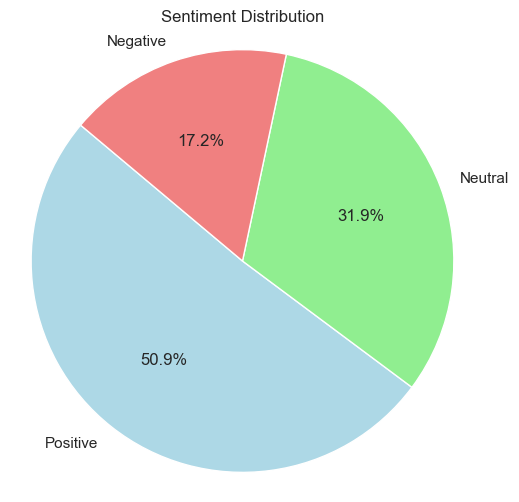

In [200]:
#import matplotlib.pyplot as plt

# Count the sentiment categories
sentiment_counts = df2['Sentiment'].value_counts()

# Plot a pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['lightblue', 'lightgreen', 'lightcoral'] 
)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [ ]:
#Code for Sentiment Analysis using Bag of Words Vectorization Approach:

In [184]:
# Pre-Prcoessing and Bag of Word Vectorization using Count Vectorizer
#from sklearn.feature_extraction.text import CountVectorizer
cv   = CountVectorizer(ngram_range = (1, 1))
text_counts = cv.fit_transform(df2['Cleaned Comment'])
text_counts


<273x1789 sparse matrix of type '<class 'numpy.int64'>'
	with 5191 stored elements in Compressed Sparse Row format>

## MACHINE LEARNING 

In [186]:
#Splitting the data into trainig and testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, df2['Sentiment'], test_size=0.25, random_state=5)

In [188]:
df2['Sentiment'].value_counts()


Sentiment
Positive    139
Neutral      87
Negative     47
Name: count, dtype: int64

In [190]:
text_counts.shape, X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((273, 1789), (204, 1789), (69, 1789), (204,), (69,))

In [192]:
# Training the model USING Multinomial naives bayes classifier 
#from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB(alpha=1)
MNB.fit(X_train, Y_train)



MultinomialNB(alpha=1)

In [212]:
# Caluclating the accuracy score of the model
#from sklearn import metrics
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracy Score: ",accuracy_score)

Accuracy Score:  0.6086956521739131


## EVALUATION

In [214]:
#classification report

#from sklearn.metrics import classification_report

# Instantiate a mthod named as Cla
cf = classification_report(Y_test, predicted)

# Display the values of an object cf
print(cf)

              precision    recall  f1-score   support

    Negative       0.38      0.27      0.32        11
     Neutral       0.48      0.67      0.56        15
    Positive       0.72      0.67      0.70        43

    accuracy                           0.61        69
   macro avg       0.53      0.54      0.52        69
weighted avg       0.62      0.61      0.61        69



Insights: Positive sentiment dominates and performs the best among all. Most samples are positive indicating class imbalance. Neutral sentiment has been fairly handled with moderate support (15) and  decent recall (0.67),  the model captures most Neutral cases. However, Negative sentiment is poorly predicted. Low recall (0.27) indicates most Negative samples are missed which may be due to class imbalance or small sample size. 

## EXTRA WORK

In [ ]:
#code for publishing results on dashboard

In [216]:
import sys
import subprocess

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

required_packages = ['streamlit', 'pandas', 'numpy', 'scikit-learn', 'matplotlib', 'seaborn', 'joblib']
for pkg in required_packages:
    install(pkg)


In [220]:
import joblib
# Save for dashboard
joblib.dump({
    "df2": df2,
    "accuracy_score": accuracy_score,
    "predicted" : predicted,
    "X_test": X_test,
    "Y_test": Y_test, 
    
}, "ml2_results.pkl")

['ml2_results.pkl']

In [204]:
!which python
!pip show streamlit


'which' is not recognized as an internal or external command,
operable program or batch file.


Name: streamlit
Version: 1.37.1
Summary: A faster way to build and share data apps
Home-page: https://streamlit.io
Author: Snowflake Inc
Author-email: hello@streamlit.io
License: Apache License 2.0
Location: C:\Users\Dell\anaconda3\Lib\site-packages
Requires: altair, blinker, cachetools, click, gitpython, numpy, packaging, pandas, pillow, protobuf, pyarrow, pydeck, requests, rich, tenacity, toml, tornado, typing-extensions, watchdog
Required-by: 


In [205]:
pip install plotly


In [ ]:
import subprocess
subprocess.run(["streamlit", "run", "app.py"])

## TOPIC MODELLING

In [139]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(max_df = .1,
                        max_features = 500)
X = count.fit_transform(df2['Cleaned Comment'].values)

In [141]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 10,
                                random_state = 123,
                                learning_method = 'batch')
X_topics = lda.fit_transform(X)

In [143]:
lda.components_.shape

(10, 500)

In [153]:
n_top_words = 10
feature_names = count.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
                    for i in topic.argsort()\
                        [:-n_top_words - 1:-1]]))

Topic 1:
storag work number lot much well also could time come
Topic 2:
per peaker grid ga http day mile 100 kwh com
Topic 3:
propaganda news would like know look sure ye grid also
Topic 4:
use car still ga peaker land day ethanol run gener
Topic 5:
pv day electr peopl work world instal china one right
Topic 6:
panel see one instal fact use trump benefit put everi
Topic 7:
corn even face use system produc agrivolta south pv panel
Topic 8:
blackout realli price peopl time caus charg day want imagin
Topic 9:
capac cost per would price peaker much time use output
Topic 10:
hour storag trump compani day price renew peaker ga one


In [151]:
energy = X_topics[:, 5].argsort()[::-1]

for iter_idx, movie_idx in enumerate(energy[:3]):
    print('\nenergy comment #%d:' % (iter_idx + 1))
    print(df2['Cleaned Comment'][movie_idx][:300], '...')


energy comment #1:
also worth mention german went bit irrat matter struck hard energi crisi everi aspect countri sovereignti industri bill see german put badli posit plug panel north face balconi hamburg definetli run cost benefit analysi psycholog guess yeah put dispos incom irrat behaviour wherea spain feel urgenc e ...

energy comment #2:
bit googl around look like need 190 240 pound nh3 per acr per year soy corn corn corn respect haber bosch work 200atm around 3k psi 400 600 c viabl small ish instal see immedi issu materi equip physic standpoint howev singl pass effici rather low 15 recycl gase requir separ requir extrem cold temper ...

energy comment #3:
actual sound like amaz busi idea imagin agri pv plug small electrol edg field coupl attach tank one water small haber bosch unit captur gener ammonia could farmer gener fertil excess could easili transport somewher els sale need grid connect think need crunch number one output per acr cost ...


## MACHINE LEARNING BY LOGISTIC REGRESSION MODEL

In [240]:
#logistic regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 1000, random_state = 0)
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [242]:
from sklearn import metrics
predicted = model.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracuy Score: ",accuracy_score)

Accuracuy Score:  0.5797101449275363


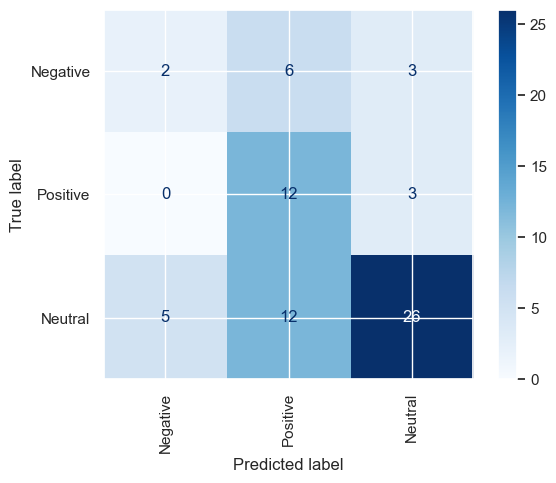

In [247]:
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay as cmd

cmd.from_estimator(model, X_test, Y_test,
                   display_labels=['Negative', 'Positive','Neutral'],
                   cmap='Blues', xticks_rotation='vertical')
import matplotlib.pyplot as plt
plt.show()